In [27]:
import pandas as pd
from sodapy import Socrata
import seaborn as sns

#aqui sacamos las tablas de datos de hospitales y desfibriladores 
client = Socrata("analisi.transparenciacatalunya.cat", None)

desfibriladors = client.get("wpud-ukyg")
hospitales = client.get("8gmd-gz7i")


df_socioeconomic = pd.read_csv("socio_eco.csv")

In [28]:

#CÓDIGO QUE LIMPIA Y PROCESA LOS DATOS SOCIOECONÓMICOS Y CENSO, DEJA UNA COLUMNA DE PUNTUACIÓN SOCIOECONÓMICA QUE USARÉ PARA EL MAPA
df_cens=pd.read_csv("cens.csv", sep=';')  # Saltar líneas problemáticas
df_cens.drop(columns=['estat', 'any', 'concepte','geo'], inplace=True)

df_cens = df_cens[~df_cens['edat'].str.contains('any', na=False)]
df_cens = df_cens[~df_cens['sexe'].str.contains('homes', na=False)]
df_cens= df_cens[~df_cens['sexe'].str.contains('dones', na=False)]
df_cens= df_cens[~df_cens['municipi'].str.contains('anys', na=False)]

df_cens.drop(columns=['edat', 'sexe'], inplace=True)

df_socioeconomic = pd.read_csv("socio_eco.csv")
df_socioeconomic = df_socioeconomic[['any', 'municipi', 'concepte', 'valor']]
# Limpiar valores vacíos o '..'
df_socioeconomic['valor'] = pd.to_numeric(df_socioeconomic['valor'], errors='coerce')

# Pivotar
df_socioeconomic = df_socioeconomic.pivot_table(
    index=['any', 'municipi'],
    columns='concepte',
    values='valor',
    aggfunc='first'
).reset_index()

# ahora sustituyo los valores NaN por la media de la columna
for column in df_socioeconomic.columns:
    if df_socioeconomic[column].dtype in ['float64', 'int64']:
        mean_value = df_socioeconomic[column].mean()
        df_socioeconomic[column].fillna(mean_value, inplace=True)

df_socioeconomic['població desocupada(%)'] = 100-df_socioeconomic['població ocupada (%)']
df_socioeconomic.drop(columns=['població ocupada (%)'], inplace=True)

#normalizo cada columna numérica sin sklearn
numeric_columns = df_socioeconomic.select_dtypes(include=['float64', 'int64']).columns
for column in numeric_columns:
    min_value = df_socioeconomic[column].min()
    max_value = df_socioeconomic[column].max()
    df_socioeconomic[column] = (df_socioeconomic[column] - min_value) / (max_value - min_value)
df_socioeconomic.drop(columns=['any'], inplace=True)
df_socioeconomic.drop(columns=['estrangers de països de renda baixa o mitjana (%)'], inplace=True)
#ahora creo una columna de puntuación de pobreza socioeconómica, que haga la media sumando o restando algunas columnas

df_socioeconomic['puntuació pobreza socioeconòmica'] = (
    df_socioeconomic['població amb estudis baixos (%)'] * (1/3) +
    df_socioeconomic['població jove sense estudis postobligatoris (%)'] * (1/6) -
    df_socioeconomic['renda mitjana per persona (€)'] * (1/3) +
    df_socioeconomic['treballadors de baixa qualificació (%)'] * (1/12) +
    df_socioeconomic['població desocupada(%)'] * (1/12)
)


C:\Users\German\AppData\Local\Temp\ipykernel_13496\1381535994.py:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens=pd.read_csv("cens.csv", sep=';')  # Saltar líneas problemáticas
C:\Users\German\AppData\Local\Temp\ipykernel_13496\1381535994.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_socioeconomic[column].fillna(mean_value, inplace=True)


Pesos del PCA:
població amb estudis baixos (%)                    0.476087
població jove sense estudis postobligatoris (%)    0.526400
treballadors de baixa qualificació (%)             0.306693
població desocupada(%)                             0.365872
renta_inv                                          0.517998
dtype: float64

Varianza explicada por la primera componente: 0.547710004148582


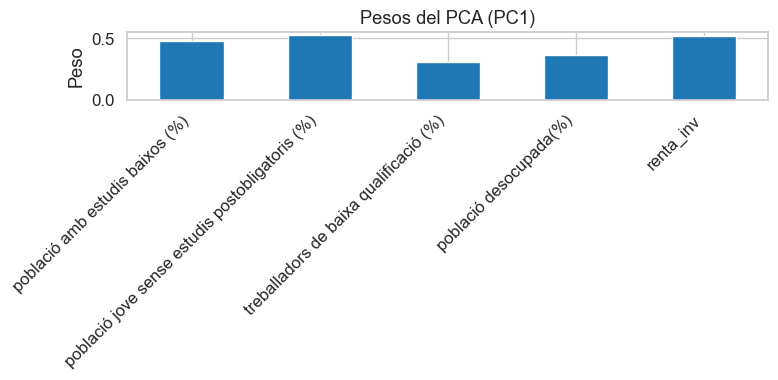

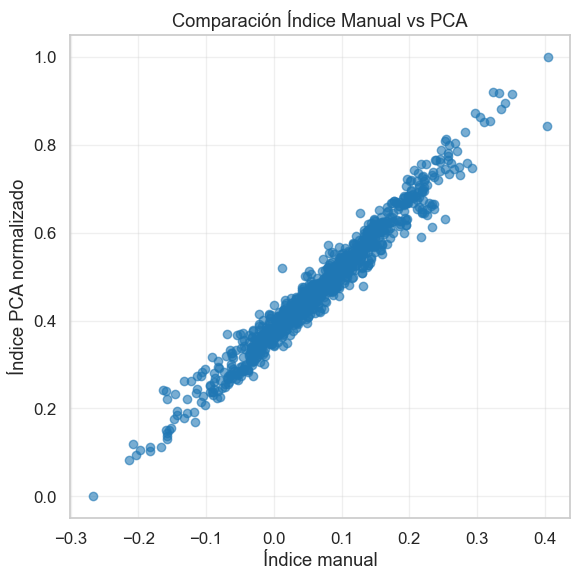

Correlación manual vs PCA = 0.9803282244785025


In [29]:
#PRUEBA DE PCA
# =========================
# GRÁFICOS DEL PCA Y COMPARACIÓN CON ÍNDICE MANUAL
# =========================

import matplotlib.pyplot as plt
# =========================
# PCA PARA ÍNDICE SOCIOECONÓMICO
# =========================
import sklearn as sk
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Variables que quieres incluir en el índice
vars_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renda mitjana per persona (€)'
]

# Invertir la renta normalizada para que mayor valor = mayor pobreza
df_socioeconomic['renta_inv'] = 1 - df_socioeconomic['renda mitjana per persona (€)']

# Preparar matriz X para el PCA
vars_for_pca = [
    'població amb estudis baixos (%)',
    'població jove sense estudis postobligatoris (%)',
    'treballadors de baixa qualificació (%)',
    'població desocupada(%)',
    'renta_inv'
]

X = df_socioeconomic[vars_for_pca].values

# Aplicar PCA con 1 componente
pca = PCA(n_components=1)
pc1 = pca.fit_transform(X)

# Guardar la componente principal como índice bruto
df_socioeconomic['indice_pca_bruto'] = pc1[:, 0]

# Normalizar a rango [0,1]
idx = df_socioeconomic['indice_pca_bruto']
df_socioeconomic['indice_pca_norm'] = (idx - idx.min()) / (idx.max() - idx.min())

# Mostrar pesos del PCA
pesos_pca = pd.Series(pca.components_[0], index=vars_for_pca)
print("Pesos del PCA:")
print(pesos_pca)

# Varianza explicada
print("\nVarianza explicada por la primera componente:", pca.explained_variance_ratio_[0])

# --- 1. Gráfico de pesos del PCA ---
plt.figure(figsize=(8,4))
pesos_pca.plot(kind='bar')
plt.title("Pesos del PCA (PC1)")
plt.ylabel("Peso")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# --- 2. Comparación del índice manual vs PCA ---
plt.figure(figsize=(6,6))
plt.scatter(
    df_socioeconomic['puntuació pobreza socioeconòmica'], 
    df_socioeconomic['indice_pca_norm'],
    alpha=0.6
)
plt.xlabel("Índice manual")
plt.ylabel("Índice PCA normalizado")
plt.title("Comparación Índice Manual vs PCA")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Correlación entre ambos índices
corr = df_socioeconomic['puntuació pobreza socioeconòmica'].corr(df_socioeconomic['indice_pca_norm'])
print("Correlación manual vs PCA =", corr)


In [30]:
df_socioeconomic 

concepte,municipi,població amb estudis baixos (%),població jove sense estudis postobligatoris (%),renda mitjana per persona (€),treballadors de baixa qualificació (%),població desocupada(%),puntuació pobreza socioeconòmica,renta_inv,indice_pca_bruto,indice_pca_norm
0,Abella de la Conca,0.449029,0.415039,0.254854,0.283945,0.445808,0.194711,0.745146,0.213786,0.629292
1,Abrera,0.305825,0.084956,0.510895,0.191136,0.278119,-0.015093,0.489105,-0.250592,0.301248
2,Agramunt,0.412621,0.433628,0.404639,0.390582,0.290389,0.131680,0.595361,0.104492,0.552085
3,Aguilar de Segarra,0.322816,0.415039,0.568501,0.283945,0.177914,0.025766,0.431499,-0.106785,0.402836
4,Agullana,0.337379,0.256637,0.707551,0.283945,0.321063,-0.030201,0.292449,-0.202888,0.334947
...,...,...,...,...,...,...,...,...,...,...
942,Viver i Serrateix,0.366505,0.415039,0.546980,0.283945,0.083845,0.039664,0.453020,-0.109255,0.401091
943,Xerta,0.398058,0.230088,0.344283,0.240997,0.546012,0.121857,0.655717,0.069328,0.527245
944,Àger,0.436893,0.260177,0.449191,0.283945,0.298569,0.087806,0.550809,-0.028047,0.458457
945,Òdena,0.347087,0.428319,0.432255,0.227147,0.292434,0.086296,0.567745,0.006816,0.483085


In [31]:
df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitales = pd.DataFrame.from_records(hospitales) 
#ahora voy a limpiar las tablas de hospitales y desfibriladores
df_desfibriladors = df_desfibriladors[['comarca', 'municipi']]
df_hospitales= df_hospitales[['poblacio','comarca']]

#4 TABLAS CONTANDO CUANTOS HOSPITALES Y DESFIBRILADORES HAY POR COMARCA Y MUNICIPIO
des_count_municipi = df_desfibriladors['municipi'].value_counts().reset_index()
des_count_comarca = df_desfibriladors['comarca'].value_counts().reset_index() 

hospi_count_municipi = df_hospitales['poblacio'].value_counts().reset_index()
hospi_count_comarca = df_hospitales['comarca'].value_counts().reset_index()

#hago un merge de las 2 tablas por municipio sumando los valores de hospitales y desfibriladores, por ejemplo
#para barcelona sumo los hospitales y desfibriladores para tener un numero total de recursos sanitarios
recursos_municipi = pd.merge(des_count_municipi, hospi_count_municipi, left_on='municipi', right_on='poblacio', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
#ahora sumo las dos columnas de recursos sanitarios en una sola
recursos_municipi['recursos_sanitaris_totals'] = recursos_municipi['count_desfibriladors'] + recursos_municipi['count_hospitals']

recursos_comarca = pd.merge(des_count_comarca, hospi_count_comarca, left_on='comarca', right_on='comarca', how='outer', suffixes=('_desfibriladors', '_hospitals')).fillna(0)
recursos_comarca['recursos_sanitaris_totals'] = recursos_comarca['count_desfibriladors'] + recursos_comarca['count_hospitals']





Percentil 96% de recursos per 1000 hab: 1.61
Comarques amb valors > p96 (capeades): Alt Urgell, Alta Ribagorça


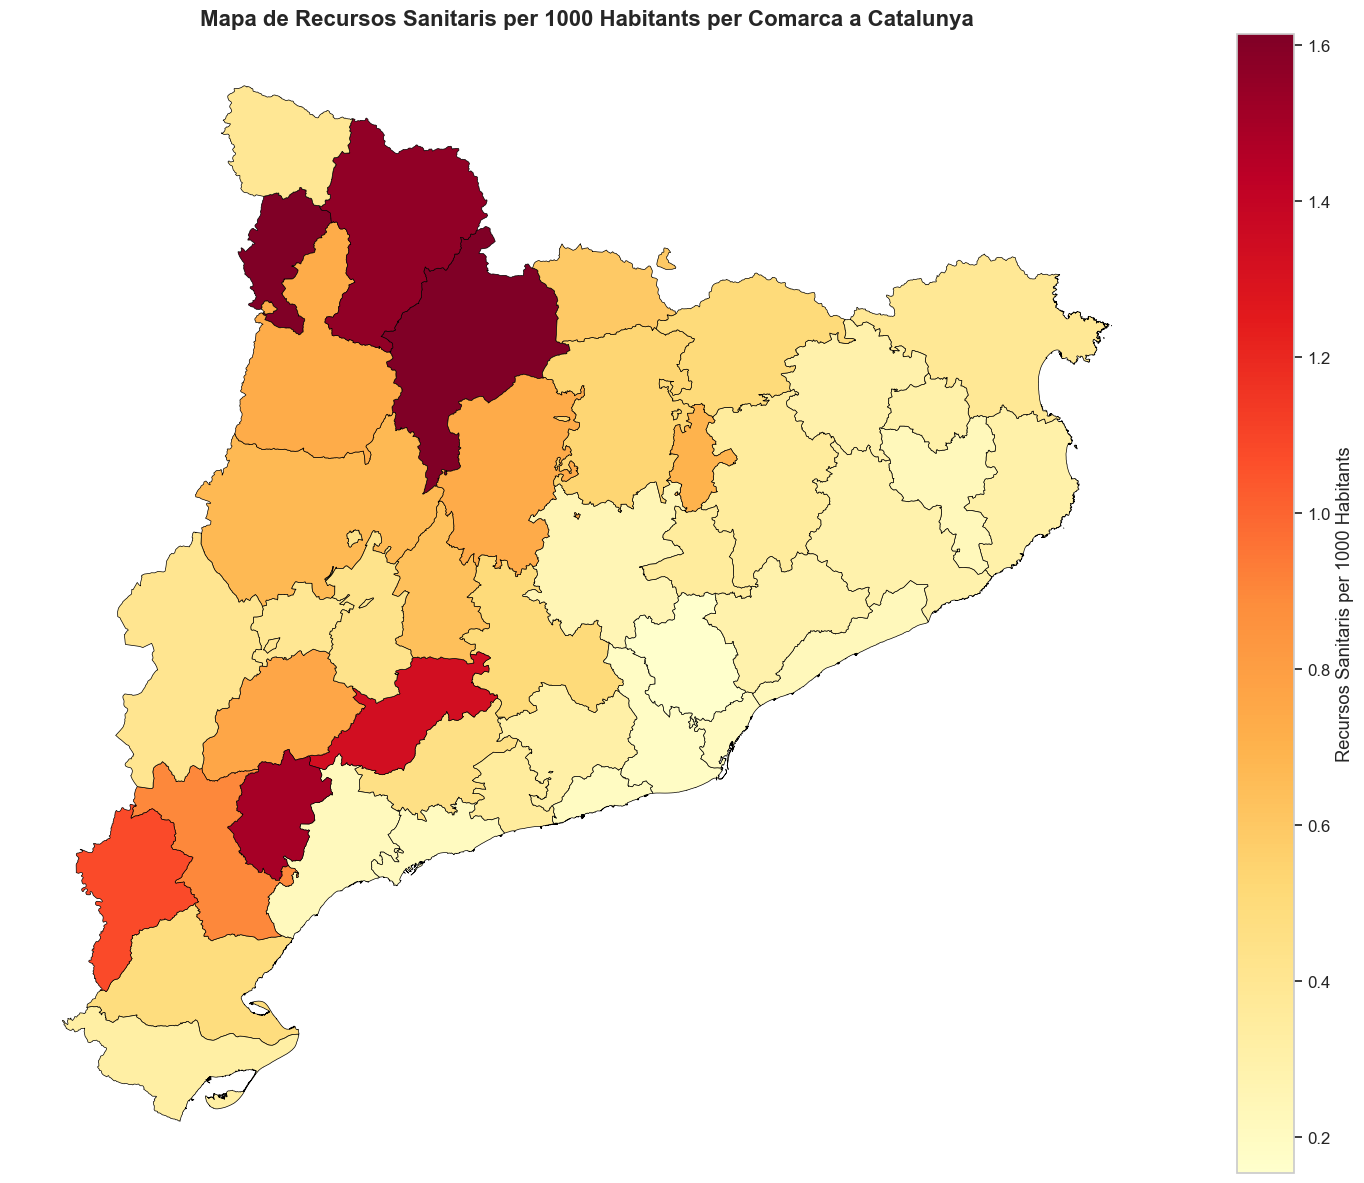

In [32]:
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = "carto/"

municipis_geo = gpd.read_file(data_dir + "muni.json")
comarcas = gpd.read_file(data_dir + "comarcas.json")

# Merge de df_cens con municipis para obtener la comarca de cada municipio
df_cens_comarca = df_cens.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                 left_on='municipi', 
                                 right_on='NOMMUNI', 
                                 how='left')

# Agrupar por comarca y sumar la población
poblacio_per_comarca = df_cens_comarca.groupby('NOMCOMAR')['valor'].sum().reset_index()
poblacio_per_comarca.columns = ['comarca', 'poblacio']

# Merge de recursos_comarca con población
recursos_comarca_poblacio = recursos_comarca.merge(poblacio_per_comarca, on='comarca', how='left')

# Calcular recursos por cada 1000 habitantes
recursos_comarca_poblacio['recursos_per_1000_hab'] = (recursos_comarca_poblacio['recursos_sanitaris_totals'] / recursos_comarca_poblacio['poblacio']) * 1000

# FILTRO DE OUTLIERS: Capear valores al percentil 96%
percentil_96 = recursos_comarca_poblacio['recursos_per_1000_hab'].quantile(0.96)
print(f"Percentil 96% de recursos per 1000 hab: {percentil_96:.2f}")

# Identificar outliers
comarcas_outliers = recursos_comarca_poblacio[recursos_comarca_poblacio['recursos_per_1000_hab'] > percentil_96]['comarca'].tolist()
if comarcas_outliers:
    print(f"Comarques amb valors > p96 (capeades): {', '.join(comarcas_outliers)}")

# Capear los valores al percentil 96 (no eliminar, solo limitar el valor máximo)
recursos_comarca_poblacio['recursos_per_1000_hab'] = recursos_comarca_poblacio['recursos_per_1000_hab'].clip(upper=percentil_96)

# Merge del mapa de comarcas con los datos de recursos por población
comarcas_recursos = comarcas.merge(recursos_comarca_poblacio, left_on='NOMCOMAR', right_on='comarca', how='left')

# Rellenar valores NaN con 0 (comarcas sin recursos)
comarcas_recursos['recursos_per_1000_hab'] = comarcas_recursos['recursos_per_1000_hab'].fillna(0)

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

comarcas_recursos.plot(column='recursos_per_1000_hab', 
                        ax=ax, 
                        legend=True,
                        cmap='YlOrRd',
                        edgecolor='black',
                        linewidth=0.5,
                        legend_kwds={'label': "Recursos Sanitaris per 1000 Habitants",
                                     'orientation': "vertical"})

ax.set_title('Mapa de Recursos Sanitaris per 1000 Habitants per Comarca a Catalunya', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

In [33]:
df_socioeconomic

concepte,municipi,població amb estudis baixos (%),població jove sense estudis postobligatoris (%),renda mitjana per persona (€),treballadors de baixa qualificació (%),població desocupada(%),puntuació pobreza socioeconòmica,renta_inv,indice_pca_bruto,indice_pca_norm
0,Abella de la Conca,0.449029,0.415039,0.254854,0.283945,0.445808,0.194711,0.745146,0.213786,0.629292
1,Abrera,0.305825,0.084956,0.510895,0.191136,0.278119,-0.015093,0.489105,-0.250592,0.301248
2,Agramunt,0.412621,0.433628,0.404639,0.390582,0.290389,0.131680,0.595361,0.104492,0.552085
3,Aguilar de Segarra,0.322816,0.415039,0.568501,0.283945,0.177914,0.025766,0.431499,-0.106785,0.402836
4,Agullana,0.337379,0.256637,0.707551,0.283945,0.321063,-0.030201,0.292449,-0.202888,0.334947
...,...,...,...,...,...,...,...,...,...,...
942,Viver i Serrateix,0.366505,0.415039,0.546980,0.283945,0.083845,0.039664,0.453020,-0.109255,0.401091
943,Xerta,0.398058,0.230088,0.344283,0.240997,0.546012,0.121857,0.655717,0.069328,0.527245
944,Àger,0.436893,0.260177,0.449191,0.283945,0.298569,0.087806,0.550809,-0.028047,0.458457
945,Òdena,0.347087,0.428319,0.432255,0.227147,0.292434,0.086296,0.567745,0.006816,0.483085


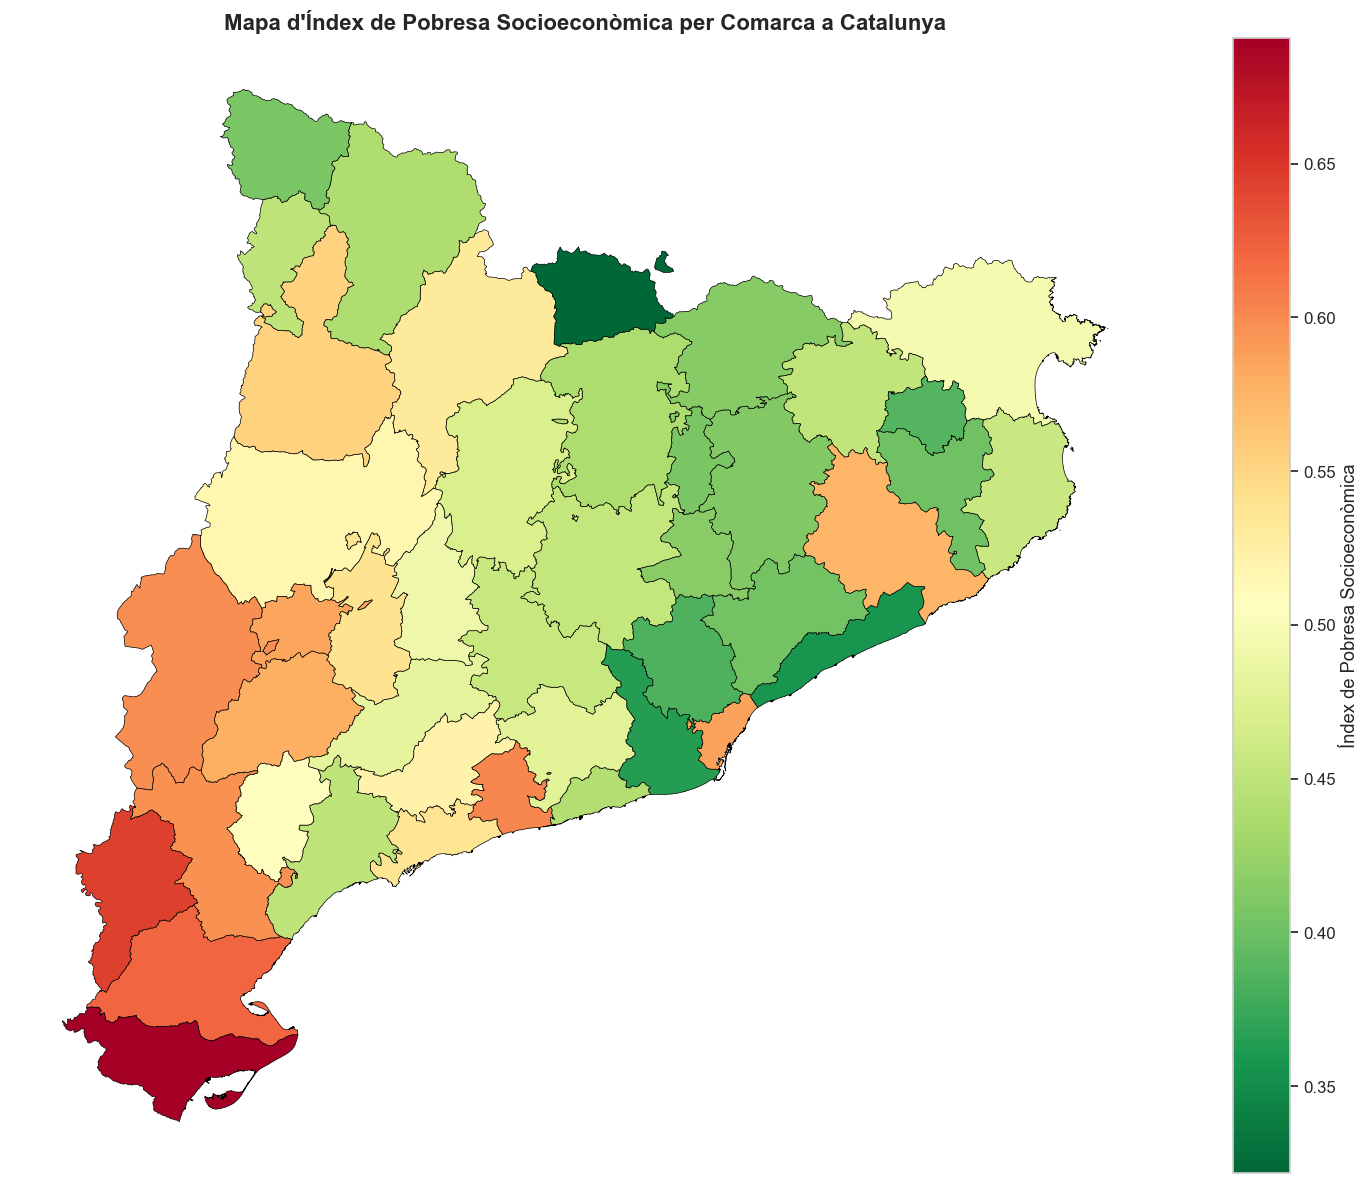

In [34]:
# Merge de df_socioeconomic con municipis_geo para obtener la comarca de cada municipio
df_socioeconomic_comarca = df_socioeconomic.merge(municipis_geo[['NOMMUNI', 'NOMCOMAR']], 
                                                    left_on='municipi', 
                                                    right_on='NOMMUNI', 
                                                    how='left')

# Calcular la media de la puntuación de pobreza socioeconómica por comarca
pobreza_per_comarca = df_socioeconomic_comarca.groupby('NOMCOMAR')['indice_pca_norm'].mean().reset_index()
pobreza_per_comarca.columns = ['comarca', 'puntuacio_pobreza']

# Merge del mapa de comarcas con los datos de pobreza socioeconómica
comarcas_pobreza = comarcas.merge(pobreza_per_comarca, left_on='NOMCOMAR', right_on='comarca', how='left')

# Rellenar valores NaN con 0 (comarcas sin datos)
comarcas_pobreza['puntuacio_pobreza'] = comarcas_pobreza['puntuacio_pobreza'].fillna(0)

# Crear el mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

comarcas_pobreza.plot(column='puntuacio_pobreza', 
                       ax=ax, 
                       legend=True,
                       cmap='RdYlGn_r',  # Rojo = más pobreza, Verde = menos pobreza
                       edgecolor='black',
                       linewidth=0.5,
                       legend_kwds={'label': "Índex de Pobresa Socioeconòmica",
                                    'orientation': "vertical"})

ax.set_title('Mapa d\'Índex de Pobresa Socioeconòmica per Comarca a Catalunya', fontsize=16, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

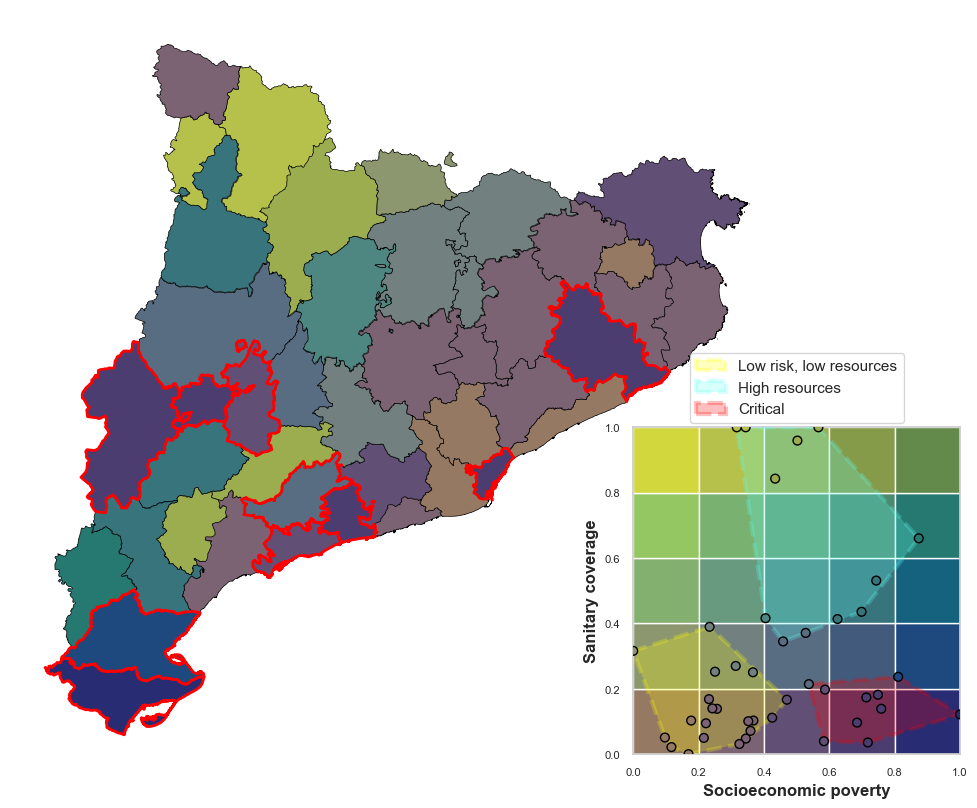

In [35]:
# ===========================================================================================================================
# MAPA 1: RECURSOS SANITARIS GENERALS VS POBRESA (3 Grupos, Cuadrado, Inset Scatter)
# ===========================================================================================================================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull

# Configurar estilo
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)

# 1. PREPARACIÓN DE DATOS
datos_combinados = recursos_comarca_poblacio.merge(pobreza_per_comarca, on='comarca', how='inner')

# CLIP AL 95% (Identificar outliers antes de clipear para el clustering)
percentil_95 = datos_combinados['recursos_per_1000_hab'].quantile(0.95)
mask_no_outliers = datos_combinados['recursos_per_1000_hab'] <= percentil_95

datos_combinados['recursos_per_1000_hab'] = datos_combinados['recursos_per_1000_hab'].clip(upper=percentil_95)

# Normalización
min_recursos = datos_combinados['recursos_per_1000_hab'].min()
max_recursos = datos_combinados['recursos_per_1000_hab'].max()
datos_combinados['recursos_norm'] = (datos_combinados['recursos_per_1000_hab'] - min_recursos) / (max_recursos - min_recursos)

min_pobreza = datos_combinados['puntuacio_pobreza'].min()
max_pobreza = datos_combinados['puntuacio_pobreza'].max()
datos_combinados['pobreza_norm'] = (datos_combinados['puntuacio_pobreza'] - min_pobreza) / (max_pobreza - min_pobreza)

# 2. CLUSTERING (3 GRUPOS) - Calculado SIN outliers
X = datos_combinados[['pobreza_norm', 'recursos_norm']].values
X_fit = X[mask_no_outliers] # Entrenar solo con datos que no eran outliers originales

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_fit)
datos_combinados['Cluster'] = kmeans.predict(X)

# Asignación de Etiquetas (Critical, High resources, Low risk low resources)
centroids = datos_combinados.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices = centroids.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels = {}
# El de menor pobreza es Low risk low resources (antes Bienestar)
cluster_labels[sorted_indices[2]] = "Low risk, low resources"

# Entre los dos de mayor pobreza, comparamos recursos
idx_a = sorted_indices[0]
idx_b = sorted_indices[1]

if centroids.loc[idx_a, 'recursos_norm'] < centroids.loc[idx_b, 'recursos_norm']:
    cluster_labels[idx_a] = "Critical"
    cluster_labels[idx_b] = "High resources"
else:
    cluster_labels[idx_a] = "High resources"
    cluster_labels[idx_b] = "Critical"

# Asignar etiquetas al dataframe
datos_combinados['label'] = datos_combinados['Cluster'].map(cluster_labels)

# 3. DISCRETIZACIÓN Y COLORES
n_bins = 5
datos_combinados['pobreza_bin'] = np.floor(datos_combinados['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_combinados['recursos_bin'] = np.floor(datos_combinados['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

colors_pobreza = plt.cm.cividis_r(np.linspace(0, 1, 256))
cmap_pobreza = LinearSegmentedColormap.from_list('pobreza', colors_pobreza)
colors_recursos = plt.cm.viridis(np.linspace(0, 1, 256))
cmap_recursos = LinearSegmentedColormap.from_list('recursos', colors_recursos)

def get_discrete_color(pobreza_bin, recursos_bin, n_bins):
    pobreza_val = (pobreza_bin + 0.5) / n_bins
    recursos_val = (recursos_bin + 0.5) / n_bins
    col_pob = cmap_pobreza(pobreza_val)[:3]
    col_rec = cmap_recursos(recursos_val)[:3]
    return [(col_pob[0] + col_rec[0])/2, (col_pob[1] + col_rec[1])/2, (col_pob[2] + col_rec[2])/2]

datos_combinados['color_rgb'] = datos_combinados.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_combinado = comarcas.merge(datos_combinados, left_on='NOMCOMAR', right_on='comarca', how='left')

# 4. PLOTTING (CUADRADO)
fig, ax_map = plt.subplots(1, 1, figsize=(10, 10))

# --- MAPA ---
comarcas_con_color = comarcas_combinado[comarcas_combinado['color_rgb'].notna()].copy()
comarcas_sin_color = comarcas_combinado[comarcas_combinado['color_rgb'].isna()]

if len(comarcas_sin_color) > 0:
    comarcas_sin_color.plot(ax=ax_map, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color.iterrows():
    comarcas_con_color.loc[[idx]].plot(ax=ax_map, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# --- RESALTAR COMARCAS CRÍTICAS ---
comarcas_criticas = comarcas_combinado[comarcas_combinado['label'] == 'Critical']
if not comarcas_criticas.empty:
    comarcas_criticas.plot(ax=ax_map, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map.axis('off')
# Sin título general

# --- INSET SCATTER (Esquina inferior derecha) ---
# Coordenadas relativas [x, y, width, height]
ax_scatter = ax_map.inset_axes([0.80, 0.02, 0.43, 0.43])
# Fondo Bivariante
for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter.add_patch(rect)

# Clusters (Convex Hulls)
# Critical -> Red, High resources -> Green, Low risk... -> Yellow
cluster_colors = {'Critical': '#FF0000', 'High resources': "#60FFF2", 'Low risk, low resources': '#FFFF00'}
unique_clusters = np.sort(datos_combinados['Cluster'].unique())

for cluster in unique_clusters:
    cluster_data = datos_combinados[datos_combinados['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter.add_patch(poly)

# Puntos
ax_scatter.scatter(
    datos_combinados['pobreza_norm'],
    datos_combinados['recursos_norm'],
    c=datos_combinados['color_rgb'],
    s=40, # Más pequeños
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter.set_xlim(0, 1)
ax_scatter.set_ylim(0, 1)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlabel('Socioeconomic poverty', fontsize=12, fontweight='bold')
ax_scatter.set_ylabel('Sanitary coverage', fontsize=12, fontweight='bold')
ax_scatter.tick_params(labelsize=8)
ax_scatter.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=11, ncol=1)
plt.savefig('mapa_recursos_vs_pobreza.png', dpi=600, bbox_inches='tight')
plt.show()

In [36]:
df_socioeconomic

concepte,municipi,població amb estudis baixos (%),població jove sense estudis postobligatoris (%),renda mitjana per persona (€),treballadors de baixa qualificació (%),població desocupada(%),puntuació pobreza socioeconòmica,renta_inv,indice_pca_bruto,indice_pca_norm
0,Abella de la Conca,0.449029,0.415039,0.254854,0.283945,0.445808,0.194711,0.745146,0.213786,0.629292
1,Abrera,0.305825,0.084956,0.510895,0.191136,0.278119,-0.015093,0.489105,-0.250592,0.301248
2,Agramunt,0.412621,0.433628,0.404639,0.390582,0.290389,0.131680,0.595361,0.104492,0.552085
3,Aguilar de Segarra,0.322816,0.415039,0.568501,0.283945,0.177914,0.025766,0.431499,-0.106785,0.402836
4,Agullana,0.337379,0.256637,0.707551,0.283945,0.321063,-0.030201,0.292449,-0.202888,0.334947
...,...,...,...,...,...,...,...,...,...,...
942,Viver i Serrateix,0.366505,0.415039,0.546980,0.283945,0.083845,0.039664,0.453020,-0.109255,0.401091
943,Xerta,0.398058,0.230088,0.344283,0.240997,0.546012,0.121857,0.655717,0.069328,0.527245
944,Àger,0.436893,0.260177,0.449191,0.283945,0.298569,0.087806,0.550809,-0.028047,0.458457
945,Òdena,0.347087,0.428319,0.432255,0.227147,0.292434,0.086296,0.567745,0.006816,0.483085


In [37]:
#hago una nueva tabla que deje indice_pca_bruto por comarca
indice_comarca = df_socioeconomic_comarca.groupby('NOMCOMAR')['indice_pca_norm'].mean().reset_index()
indice_comarca.columns = ['comarca', 'indice_pca_norm']

In [44]:
# Normalizar de 0 a 1 la columna indice_pca_norm
min_val = indice_comarca['indice_pca_norm'].min()
max_val = indice_comarca['indice_pca_norm'].max()
indice_comarca['indice_pca_norm'] = (indice_comarca['indice_pca_norm'] - min_val) / (max_val - min_val)
#lo guardo en un csv
indice_comarca.to_csv('indice_comarca_normalized.csv', index=False)
indice_comarca

,comarca,indice_pca_norm
0,Alt Camp,0.537578
1,Alt Empordà,0.469938
2,Alt Penedès,0.425215
3,Alt Urgell,0.566693
4,Alta Ribagorça,0.344013
5,Anoia,0.366418
6,Bages,0.358903
7,Baix Camp,0.344675
8,Baix Ebre,0.810657
9,Baix Empordà,0.367822


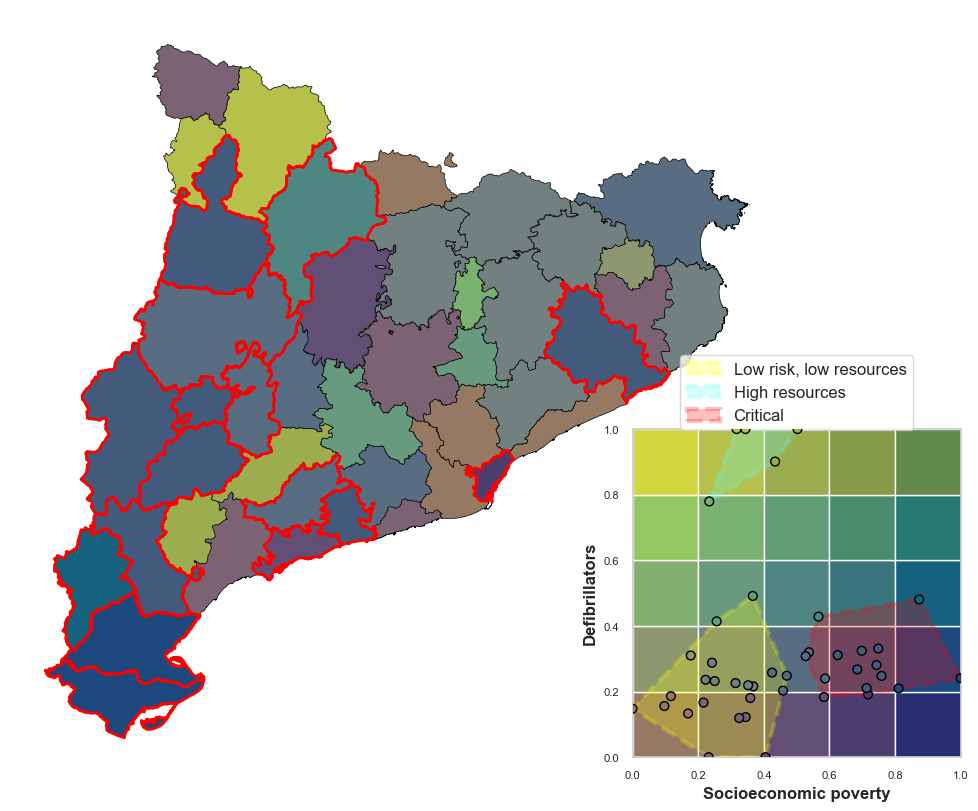

In [39]:
# ===========================================================================================================================
# MAPA 2: DESFIBRILADORS VS POBRESA (3 Grupos, Cuadrado, Inset Scatter)
# ===========================================================================================================================

# 1. PREPARACIÓN DE DATOS
desfib_per_comarca = recursos_comarca[['comarca', 'count_desfibriladors']].copy()
desfib_per_comarca = desfib_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
desfib_per_comarca['desfib_per_1000_hab'] = (desfib_per_comarca['count_desfibriladors'] / desfib_per_comarca['poblacio']) * 1000

datos_desfib = desfib_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# CLIP AL 95%
percentil_95_d = datos_desfib['desfib_per_1000_hab'].quantile(0.95)
datos_desfib['desfib_per_1000_hab'] = datos_desfib['desfib_per_1000_hab'].clip(upper=percentil_95_d)

# Normalización
min_recursos_d = datos_desfib['desfib_per_1000_hab'].min()
max_recursos_d = datos_desfib['desfib_per_1000_hab'].max()
datos_desfib['recursos_norm'] = (datos_desfib['desfib_per_1000_hab'] - min_recursos_d) / (max_recursos_d - min_recursos_d)

min_pobreza_d = datos_desfib['puntuacio_pobreza'].min()
max_pobreza_d = datos_desfib['puntuacio_pobreza'].max()
datos_desfib['pobreza_norm'] = (datos_desfib['puntuacio_pobreza'] - min_pobreza_d) / (max_pobreza_d - min_pobreza_d)

# 2. CLUSTERING (3 GRUPOS)
X_d = datos_desfib[['pobreza_norm', 'recursos_norm']].values

kmeans_d = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_d.fit(X_d)
datos_desfib['Cluster'] = kmeans_d.predict(X_d)

# Asignación de Etiquetas
centroids_d = datos_desfib.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices_d = centroids_d.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels_d = {}
cluster_labels_d[sorted_indices_d[2]] = "Low risk, low resources"

idx_a = sorted_indices_d[0]
idx_b = sorted_indices_d[1]

if centroids_d.loc[idx_a, 'recursos_norm'] < centroids_d.loc[idx_b, 'recursos_norm']:
    cluster_labels_d[idx_a] = "Critical"
    cluster_labels_d[idx_b] = "High resources"
else:
    cluster_labels_d[idx_a] = "High resources"
    cluster_labels_d[idx_b] = "Critical"

# Asignar etiquetas al dataframe
datos_desfib['label'] = datos_desfib['Cluster'].map(cluster_labels_d)

# 3. DISCRETIZACIÓN Y COLORES
n_bins = 5
datos_desfib['pobreza_bin'] = np.floor(datos_desfib['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_desfib['recursos_bin'] = np.floor(datos_desfib['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

datos_desfib['color_rgb'] = datos_desfib.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_desfib = comarcas.merge(datos_desfib, left_on='NOMCOMAR', right_on='comarca', how='left')

# 4. PLOTTING
fig, ax_map_d = plt.subplots(1, 1, figsize=(10, 10))

# Mapa
comarcas_con_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].notna()].copy()
comarcas_sin_color_d = comarcas_desfib[comarcas_desfib['color_rgb'].isna()]

if len(comarcas_sin_color_d) > 0:
    comarcas_sin_color_d.plot(ax=ax_map_d, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_d.iterrows():
    comarcas_con_color_d.loc[[idx]].plot(ax=ax_map_d, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# --- RESALTAR COMARCAS CRÍTICAS ---
comarcas_criticas_d = comarcas_desfib[comarcas_desfib['label'] == 'Critical']
if not comarcas_criticas_d.empty:
    comarcas_criticas_d.plot(ax=ax_map_d, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map_d.axis('off')

# Inset Scatter
ax_scatter_d = ax_map_d.inset_axes([0.80, 0.02, 0.43, 0.43])

for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter_d.add_patch(rect)

unique_clusters_d = np.sort(datos_desfib['Cluster'].unique())

for cluster in unique_clusters_d:
    cluster_data = datos_desfib[datos_desfib['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels_d[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter_d.add_patch(poly)

ax_scatter_d.scatter(
    datos_desfib['pobreza_norm'],
    datos_desfib['recursos_norm'],
    c=datos_desfib['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter_d.set_xlim(0, 1)
ax_scatter_d.set_ylim(0, 1)
ax_scatter_d.set_aspect('equal')
ax_scatter_d.set_xlabel('Socioeconomic poverty', fontsize=12, fontweight='bold')
ax_scatter_d.set_ylabel('Defibrillators', fontsize=12, fontweight='bold')
ax_scatter_d.tick_params(labelsize=8)
ax_scatter_d.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=12, ncol=1)

plt.show()

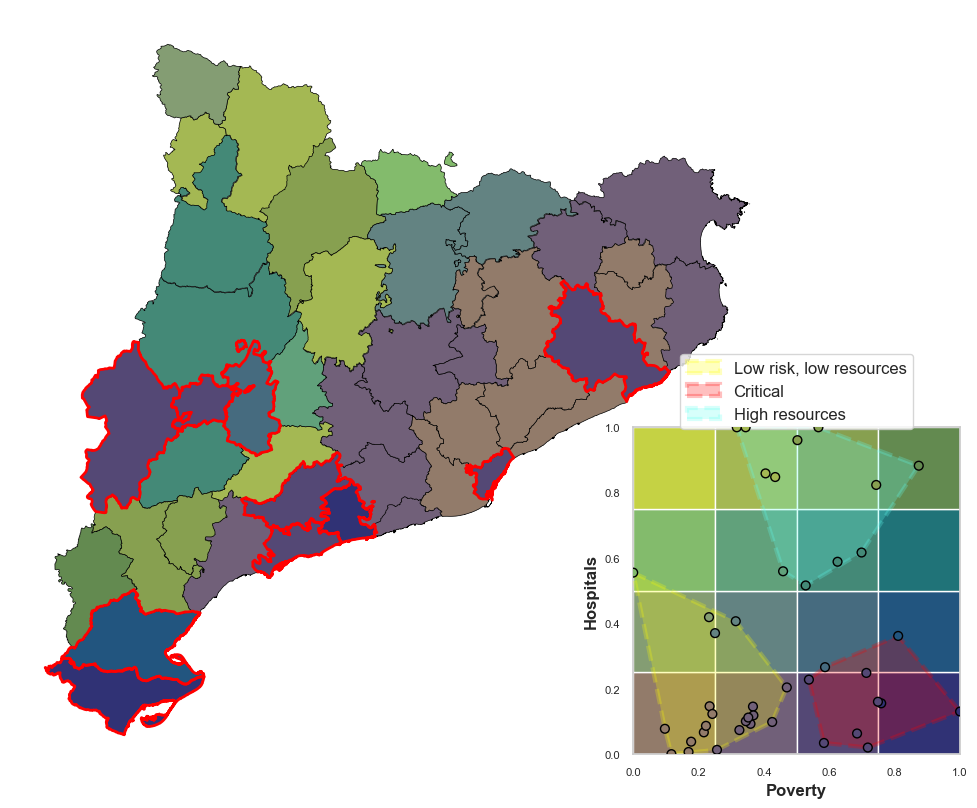

In [40]:
# ===========================================================================================================================
# MAPA 3: HOSPITALS VS POBRESA (3 Grupos, Cuadrado, Inset Scatter)
# ===========================================================================================================================

# 1. PREPARACIÓN DE DATOS
hospi_per_comarca = recursos_comarca[['comarca', 'count_hospitals']].copy()
hospi_per_comarca = hospi_per_comarca.merge(poblacio_per_comarca, on='comarca', how='left')
hospi_per_comarca['hospi_per_1000_hab'] = (hospi_per_comarca['count_hospitals'] / hospi_per_comarca['poblacio']) * 1000

datos_hospi = hospi_per_comarca.merge(pobreza_per_comarca, on='comarca', how='inner')

# CLIP AL 95%
percentil_95_h = datos_hospi['hospi_per_1000_hab'].quantile(0.95)
datos_hospi['hospi_per_1000_hab'] = datos_hospi['hospi_per_1000_hab'].clip(upper=percentil_95_h)

# Normalización
min_recursos_h = datos_hospi['hospi_per_1000_hab'].min()
max_recursos_h = datos_hospi['hospi_per_1000_hab'].max()
datos_hospi['recursos_norm'] = (datos_hospi['hospi_per_1000_hab'] - min_recursos_h) / (max_recursos_h - min_recursos_h)

min_pobreza_h = datos_hospi['puntuacio_pobreza'].min()
max_pobreza_h = datos_hospi['puntuacio_pobreza'].max()
datos_hospi['pobreza_norm'] = (datos_hospi['puntuacio_pobreza'] - min_pobreza_h) / (max_pobreza_h - min_pobreza_h)

# 2. CLUSTERING (3 GRUPOS)
X_h = datos_hospi[['pobreza_norm', 'recursos_norm']].values

kmeans_h = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_h.fit(X_h)
datos_hospi['Cluster'] = kmeans_h.predict(X_h)

# Asignación de Etiquetas
centroids_h = datos_hospi.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()
sorted_indices_h = centroids_h.sort_values('pobreza_norm', ascending=False).index.tolist()

cluster_labels_h = {}
cluster_labels_h[sorted_indices_h[2]] = "Low risk, low resources"

idx_a = sorted_indices_h[0]
idx_b = sorted_indices_h[1]

if centroids_h.loc[idx_a, 'recursos_norm'] < centroids_h.loc[idx_b, 'recursos_norm']:
    cluster_labels_h[idx_a] = "Critical"
    cluster_labels_h[idx_b] = "High resources"
else:
    cluster_labels_h[idx_a] = "High resources"
    cluster_labels_h[idx_b] = "Critical"

# Asignar etiquetas al dataframe
datos_hospi['label'] = datos_hospi['Cluster'].map(cluster_labels_h)

# 3. DISCRETIZACIÓN Y COLORES
n_bins = 4
datos_hospi['pobreza_bin'] = np.floor(datos_hospi['pobreza_norm'] * n_bins).clip(0, n_bins-1).astype(int)
datos_hospi['recursos_bin'] = np.floor(datos_hospi['recursos_norm'] * n_bins).clip(0, n_bins-1).astype(int)

datos_hospi['color_rgb'] = datos_hospi.apply(
    lambda row: get_discrete_color(row['pobreza_bin'], row['recursos_bin'], n_bins), axis=1
)

comarcas_hospi = comarcas.merge(datos_hospi, left_on='NOMCOMAR', right_on='comarca', how='left')

# 4. PLOTTING
fig, ax_map_h = plt.subplots(1, 1, figsize=(10, 10))

# Mapa
comarcas_con_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].notna()].copy()
comarcas_sin_color_h = comarcas_hospi[comarcas_hospi['color_rgb'].isna()]

if len(comarcas_sin_color_h) > 0:
    comarcas_sin_color_h.plot(ax=ax_map_h, color='lightgray', edgecolor='black', linewidth=0.5)

for idx, row in comarcas_con_color_h.iterrows():
    comarcas_con_color_h.loc[[idx]].plot(ax=ax_map_h, color=[row['color_rgb']], edgecolor='black', linewidth=0.5)

# --- RESALTAR COMARCAS CRÍTICAS ---
comarcas_criticas_h = comarcas_hospi[comarcas_hospi['label'] == 'Critical']
if not comarcas_criticas_h.empty:
    comarcas_criticas_h.plot(ax=ax_map_h, facecolor='none', edgecolor='red', linewidth=2.0, zorder=5)

ax_map_h.axis('off')

# Inset Scatter
ax_scatter_h = ax_map_h.inset_axes([0.80, 0.02, 0.43, 0.43])

for i in range(n_bins):
    for j in range(n_bins):
        color = get_discrete_color(i, j, n_bins)
        rect = Rectangle((i/n_bins, j/n_bins), 1/n_bins, 1/n_bins, 
                         facecolor=color, edgecolor='white', alpha=1, zorder=1)
        ax_scatter_h.add_patch(rect)

unique_clusters_h = np.sort(datos_hospi['Cluster'].unique())

for cluster in unique_clusters_h:
    cluster_data = datos_hospi[datos_hospi['Cluster'] == cluster]
    points = cluster_data[['pobreza_norm', 'recursos_norm']].values
    label_name = cluster_labels_h[cluster]
    color_hull = cluster_colors.get(label_name, 'gray')
    
    if len(points) >= 3:
        hull = ConvexHull(points)
        pts = points[hull.vertices]
        poly = Polygon(pts, facecolor=color_hull, edgecolor=color_hull,
                       alpha=0.25, linewidth=3, linestyle='--', zorder=5, label=label_name)
        ax_scatter_h.add_patch(poly)

ax_scatter_h.scatter(
    datos_hospi['pobreza_norm'],
    datos_hospi['recursos_norm'],
    c=datos_hospi['color_rgb'],
    s=40,
    edgecolor='black',
    linewidth=1,
    zorder=10,
    alpha=1
)

ax_scatter_h.set_xlim(0, 1)
ax_scatter_h.set_ylim(0, 1)
ax_scatter_h.set_aspect('equal')
ax_scatter_h.set_xlabel('Poverty', fontsize=12, fontweight='bold')
ax_scatter_h.set_ylabel('Hospitals', fontsize=12, fontweight='bold')
ax_scatter_h.tick_params(labelsize=8)
ax_scatter_h.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=12, ncol=1)

plt.show()

✅ DataFrame detectado: 'datos_combinados'
   -> Normalizada columna de recursos desde 'recursos_per_1000_hab'

 1. RANKING DE VULNERABILIDAD SANITARIA
     comarca  Indice_Prioridad  recursos_per_1000_hab  puntuacio_pobreza
     Montsià          1.878408               0.324392           0.690868
  Barcelonès          1.682132               0.204150           0.586720
Baix Penedès          1.619974               0.348590           0.601858
       Selva          1.588445               0.289221           0.574568
   Baix Ebre          1.574104               0.485338           0.620980
      Segrià          1.567080               0.408561           0.598145
  Tarragonès          1.544035               0.209555           0.537172
Pla d'Urgell          1.539821               0.397062           0.585052
      Urgell          1.389514               0.430559           0.538404
    Alt Camp          1.323322               0.454122           0.520184

 2. CLUSTERING: TIPOLOGÍAS DE COMARCAS


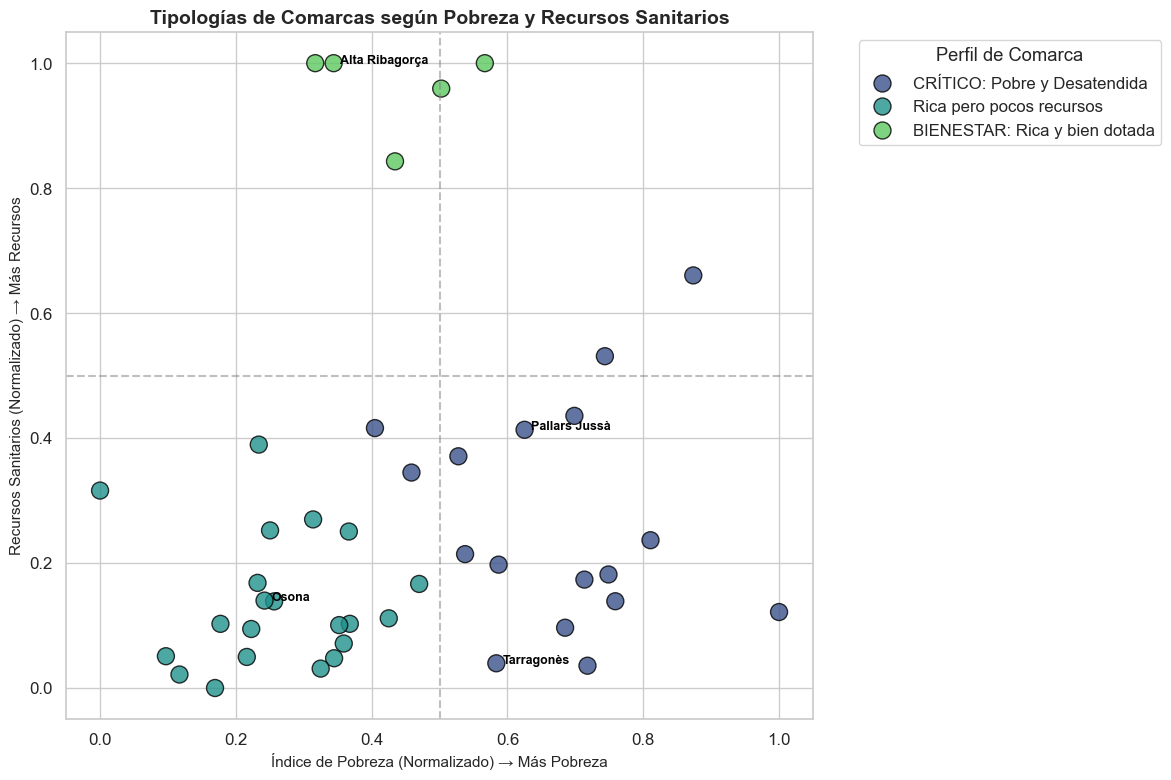


Resumen de los grupos encontrados:
Etiqueta_Cluster
Rica pero pocos recursos         21
CRÍTICO: Pobre y Desatendida     17
BIENESTAR: Rica y bien dotada     5
Name: count, dtype: int64


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# ==============================================================================
# 1. PREPARACIÓN ROBUSTA DE DATOS (Detecta tus variables automáticamente)
# ==============================================================================

# Intentamos cargar el DataFrame más completo que tengas en memoria
if 'datos_combinados' in locals():
    df_analisis = datos_combinados.copy()
    print("✅ DataFrame detectado: 'datos_combinados'")
elif 'datos_combinados_filtrados' in locals():
    df_analisis = datos_combinados_filtrados.copy()
    print("✅ DataFrame detectado: 'datos_combinados_filtrados'")
else:
    raise ValueError("❌ ERROR: No encuentro el DataFrame final. Ejecuta primero las celdas de los mapas.")

# --- GARANTIZAR COLUMNA DE POBREZA (0 a 1) ---
if 'pobreza_norm' in df_analisis.columns:
    col_pobreza = 'pobreza_norm'
else:
    # Si no existe, la creamos desde la puntuación original
    col_origen = 'puntuacio_pobreza' if 'puntuacio_pobreza' in df_analisis.columns else 'indice_pca_norm'
    df_analisis['pobreza_norm'] = (df_analisis[col_origen] - df_analisis[col_origen].min()) / \
                                  (df_analisis[col_origen].max() - df_analisis[col_origen].min())
    col_pobreza = 'pobreza_norm'
    print(f"   -> Normalizada columna de pobreza desde '{col_origen}'")

# --- GARANTIZAR COLUMNA DE RECURSOS (0 a 1) ---
# Buscamos la columna de recursos original disponible
posibles_recursos = ['recursos_sin_norm', 'recursos_per_1000_hab', 'desfib_per_1000_hab']
col_recursos_orig = next((c for c in posibles_recursos if c in df_analisis.columns), None)

if col_recursos_orig is None:
    raise ValueError("❌ No encuentro columnas de recursos (recursos_sin_norm, etc).")

# Recalculamos la normalización siempre para asegurar que esté actualizada
df_analisis['recursos_norm'] = (df_analisis[col_recursos_orig] - df_analisis[col_recursos_orig].min()) / \
                               (df_analisis[col_recursos_orig].max() - df_analisis[col_recursos_orig].min())
print(f"   -> Normalizada columna de recursos desde '{col_recursos_orig}'")


# ==============================================================================
# 2. GENERACIÓN DEL RANKING DE PRIORIDAD
# ==============================================================================
print(f"\n{'='*60}\n 1. RANKING DE VULNERABILIDAD SANITARIA\n{'='*60}")

# Fórmula: (Pobreza Alta) + (Recursos Bajos) = Mayor Prioridad
# Invertimos recursos: 1 - recursos_norm (para que 1 sea "muy mal estado")
df_analisis['Indice_Prioridad'] = df_analisis['pobreza_norm'] + (1 - df_analisis['recursos_norm'])

# Mostrar Top 10
top_prioridad = df_analisis.sort_values('Indice_Prioridad', ascending=False).head(10)
display_cols = ['comarca', 'Indice_Prioridad', col_recursos_orig, 'puntuacio_pobreza']
print(top_prioridad[display_cols].to_string(index=False))


# ==============================================================================
# 3. CLUSTERING (K-MEANS) - PERFILES DE COMARCAS
# ==============================================================================
print(f"\n{'='*60}\n 2. CLUSTERING: TIPOLOGÍAS DE COMARCAS\n{'='*60}")

# Preparamos datos X, Y
X = df_analisis[['pobreza_norm', 'recursos_norm']].values

# Ejecutamos K-Means con 4 grupos
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_analisis['Cluster'] = kmeans.fit_predict(X)

# Asignamos nombres descriptivos a los clusters (automáticamente según sus centroides)
centroides = df_analisis.groupby('Cluster')[['pobreza_norm', 'recursos_norm']].mean()

nombres_cluster = {}
for i, row in centroides.iterrows():
    pob = row['pobreza_norm']
    rec = row['recursos_norm']
    
    # Lógica simple para nombrar grupos
    if pob > 0.5 and rec < 0.5: etiqueta = "CRÍTICO: Pobre y Desatendida"
    elif pob > 0.5 and rec >= 0.5: etiqueta = "Vulnerable pero con recursos"
    elif pob <= 0.5 and rec < 0.5: etiqueta = "Rica pero pocos recursos"
    else: etiqueta = "BIENESTAR: Rica y bien dotada"
    nombres_cluster[i] = etiqueta

df_analisis['Etiqueta_Cluster'] = df_analisis['Cluster'].map(nombres_cluster)

# --- VISUALIZACIÓN ---
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(
    data=df_analisis, 
    x='pobreza_norm', 
    y='recursos_norm', 
    hue='Etiqueta_Cluster', 
    palette='viridis', 
    s=150,
    edgecolor='black',
    alpha=0.8
)

# Etiquetas de texto para las comarcas más extremas de cada grupo
for cluster in df_analisis['Cluster'].unique():
    # Coger la comarca más representativa (cercana al centroide) o aleatoria del grupo
    sample = df_analisis[df_analisis['Cluster'] == cluster].sample(1)
    plt.text(
        sample['pobreza_norm'].values[0]+0.01, 
        sample['recursos_norm'].values[0], 
        sample['comarca'].values[0], 
        fontsize=9, 
        weight='bold',
        color='black'
    )

plt.title('Tipologías de Comarcas según Pobreza y Recursos Sanitarios', fontsize=14, weight='bold')
plt.xlabel('Índice de Pobreza (Normalizado) → Más Pobreza', fontsize=11)
plt.ylabel('Recursos Sanitarios (Normalizado) → Más Recursos', fontsize=11)
plt.axvline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Perfil de Comarca")
plt.tight_layout()
plt.show()

# Resumen de grupos
print("\nResumen de los grupos encontrados:")
print(df_analisis['Etiqueta_Cluster'].value_counts())